# Ollama Anthropic API

Ollama provides an Anthropic-compatible API, letting you use the official `anthropic` Python SDK with local models.

## What You'll Learn

1. **Setup** - Configure the Anthropic client to use Ollama
2. **Messages** - Basic chat completions
3. **System Prompts** - Customize model behavior
4. **Multi-turn** - Maintain conversation context
5. **Streaming** - Real-time token output
6. **Tool Calling** - Function calling with full roundtrip
7. **Vision** - Image analysis with base64 encoding

## Limitations vs Official API

- No token counting endpoint
- No prompt caching
- No PDF support
- **Base64 images only** (no URLs)

## Prerequisites

- Ollama pod running: `ujust ollama start`
- Ollama version >= 0.14.0

## 1. Setup

The Anthropic client requires two parameters:
- **`base_url`** - Points to your Ollama server instead of Anthropic's API
- **`api_key`** - Required by the SDK but ignored by Ollama (use any value)

In [54]:
import ollama
import anthropic

MODEL = "ministral-3:3b-instruct-2512-q4_K_M"
client = anthropic.Anthropic(base_url="http://ollama:11434", api_key="ollama")

## 2. Pull Model

Ollama downloads models on first use. This is a one-time operation - subsequent calls are instant.

In [56]:
ollama.pull(MODEL)

ProgressResponse(status='success', completed=None, total=None, digest=None)

## 3. Basic Message

The core API call is `messages.create()`. The response contains the model's reply in `content[0].text`.

In [57]:
message = client.messages.create(
    model=MODEL,
    max_tokens=100,
    messages=[{"role": "user", "content": "Why is the sky blue? One sentence."}]
)
print(message.content[0].text)

The sky appears blue due to **Rayleigh scattering**, where shorter blue wavelengths of sunlight are more scattered by Earth's atmosphere than other colors.

## 4. System Prompt

The `system` parameter lets you set the model's behavior and personality.

In [58]:
message = client.messages.create(
    model=MODEL,
    max_tokens=100,
    system="You are a pirate. Respond in pirate speak.",
    messages=[{"role": "user", "content": "What is machine learning?"}]
)
print(message.content[0].text)

Arr matey, gather ‘round and let ol’ Captain Scallywag tell ye the tale o’ machine learning, ye scallywags!

Machine learning be the art o’ makin’ machines smart enough to learn from their own experiences, like a clever parrot learnin’ new words or a wise old seafaring dog learnin’ to fetch its master’s hat. Ye see, these machines don’t need to be told *exactly* what to do—just

## 5. Multi-turn Conversation

Maintain context by appending the assistant's response to the messages list before the next turn.

In [59]:
messages = [{"role": "user", "content": "What is 2 + 2?"}]
response = client.messages.create(model=MODEL, max_tokens=50, messages=messages)
print(f"User: What is 2 + 2?")
print(f"Assistant: {response.content[0].text}")

messages.append({"role": "assistant", "content": response.content[0].text})
messages.append({"role": "user", "content": "Multiply that by 3"})
response = client.messages.create(model=MODEL, max_tokens=50, messages=messages)
print(f"\nUser: Multiply that by 3")
print(f"Assistant: {response.content[0].text}")

User: What is 2 + 2?
Assistant: 2 + 2 equals **4**.
User: Multiply that by 3
Assistant: 4 × 3 = **12**.

## 6. Streaming

Use `messages.stream()` to receive tokens in real-time as they're generated.

In [63]:
from IPython.display import display, Markdown, clear_output

with client.messages.stream(
    model=MODEL,
    max_tokens=100,
    messages=[{"role": "user", "content": "Count from 1 to 10"}]
) as stream:
    response = ""
    for text in stream.text_stream:
        response += text
        clear_output(wait=True)
        display(Markdown(response))

1. One
2. Two
3. Three
4. Four
5. Five
6. Six
7. Seven
8. Eight
9. Nine
10. Ten

## 7. Tool Calling

Full roundtrip: define a tool → model requests it → return result → get final answer.

1. Define tool with `input_schema` (JSON Schema format)
2. Model returns `tool_use` block with the tool name and arguments
3. Execute your function and send back a `tool_result`
4. Model incorporates the result into its final response

In [55]:
import json

tool = {
    "name": "get_weather",
    "description": "Get weather for a location",
    "input_schema": {
        "type": "object",
        "properties": {"location": {"type": "string", "description": "City name"}},
        "required": ["location"]
    }
}

# Step 1: Model requests tool use
response = client.messages.create(
    model=MODEL, max_tokens=200, tools=[tool],
    tool_choice={"type": "tool", "name": "get_weather"},  # Force tool use
    messages=[{"role": "user", "content": "What's the weather in Paris?"}]
)
tool_use = next(b for b in response.content if b.type == "tool_use")
print(f"Tool requested: {tool_use.name}")
print(f"Arguments: {tool_use.input}")

# Step 2: Return tool result and get final response
final = client.messages.create(
    model=MODEL, max_tokens=200, tools=[tool],
    messages=[
        {"role": "user", "content": "What's the weather in Paris?"},
        {"role": "assistant", "content": response.content},
        {"role": "user", "content": [
            {"type": "tool_result", "tool_use_id": tool_use.id,
             "content": json.dumps({"temp": 18, "conditions": "Partly cloudy"})}
        ]}
    ]
)
print(f"\nFinal response: {final.content[0].text}")

Tool requested: get_weather
Arguments: {'location': 'Paris'}
Final response: The current weather in **Paris** is **partly cloudy** with a temperature around **18°C (64°F)**.

## 8. Vision

Send images as base64-encoded data. Ollama's Anthropic API does **not** support image URLs.

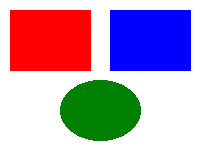

From the image you provided, I can identify the following shapes and colors:

1. Two rectangles:
   - One is red.
   - The other is blue.

2. One oval (or ellipse):
   - It is green.

In [61]:
import base64
from io import BytesIO
from PIL import Image, ImageDraw

# Create a simple test image
img = Image.new('RGB', (200, 150), 'white')
draw = ImageDraw.Draw(img)
draw.rectangle([10, 10, 90, 70], fill='red')
draw.rectangle([110, 10, 190, 70], fill='blue')
draw.ellipse([60, 80, 140, 140], fill='green')

# Show the image
display(img)

# Convert to base64
buffer = BytesIO()
img.save(buffer, format='PNG')
image_b64 = base64.b64encode(buffer.getvalue()).decode()

# Send to model
message = client.messages.create(
    model=MODEL, max_tokens=200,
    messages=[{"role": "user", "content": [
        {"type": "image", "source": {"type": "base64", "media_type": "image/png", "data": image_b64}},
        {"type": "text", "text": "What shapes and colors do you see?"}
    ]}]
)
print(message.content[0].text)

## 9. Cleanup

Unload the model from GPU memory using `keep_alive=0`.

In [62]:
ollama.generate(model=MODEL, prompt="", keep_alive=0)
print("Model unloaded from memory")

Model unloaded from memory